# Sentinel-2 Image Retrieval Using Google Earth Engine

To retrieve Sentinel-2 images from Google Earth Engine, make sure you create an account and authenticate prior to running the cell below. The link to sign up is [here](https://earthengine.google.com/new_signup/).



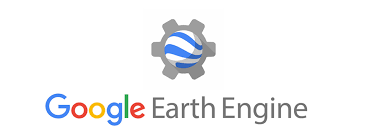

To download Sentinel-2 images we will be using the module <code>ee_download</code> and interact with the map using <code>geemap.eefolium</code>.

We use the AOI polygons retrieved from CopernicusEMS to select the location and time that we are interested in and use Google Earth Engine to do the georeferencing. Notice that we may also render the hydrography and observed flood event.

In [ ]:
# Path based modules to allow us to save files to our local machine
from pyprojroot import here
import sys
import os
root = here(project_files=[".here"])
sys.path.append(str(here()))

In [2]:
from datetime import timedelta
from datetime import datetime
import geopandas as gpd
import pandas as pd
import ee
import geemap.eefolium as geemap
import folium
from src.data import ee_download, utils
from src.data.copernicusEMS import activations


%load_ext autoreload
%autoreload 2

## Get Activation Numbers

In [63]:
csv_file = "gs://ml4cc_data_lake/0_DEV/0_Raw/WorldFloods/copernicus_ems/copernicus_ems_codes/ems_activations_20150701_20210304.csv"
table_activations_ems = pd.read_csv(csv_file, encoding="latin1")
table_activations_ems = table_activations_ems.set_index("Code")

esmr_codes = list(table_activations_ems[table_activations_ems["has_aoi"] == True].index)

In [62]:
esmr_codes[60]

'EMSR407'

In [14]:
from google.cloud import storage
from src.data.utils import remove_gcp_prefix, get_files_in_directory_gcp
from typing import Tuple
from collections import namedtuple
import tqdm
from pathlib import Path




def get_files_in_directory_gcp(bucket_id: str, directory: str, **kwargs) -> str:
    """Function to return the list of files within a given directory.

    Args:
        directory (str): Directory path to get the file list from.
        suffix (str): file extension to be listed

    Returns:
        List[str]: Returns the list of files that match the given extension
            within the given directory.
    """
    client = storage.Client(**kwargs)
    # get bucket
    bucket = client.get_bucket(bucket_id)
    # get blob
    print(directory)
    blobs = bucket.list_blobs(prefix=directory)
    # check if it exists

    # for
    files = [
        str(Path(bucket_id).joinpath(x.name)) for x in blobs
    #     if str(Path(x.name).suffix) == suffix
    ]
    
    return files

In [19]:
ActivationFile = namedtuple("ActivationFile", ["directory_aoi", "event_activation"])

# 1. Get Activation Codes, .csv file
CSV_FILE = "gs://ml4cc_data_lake/0_DEV/0_Raw/WorldFloods/copernicus_ems/copernicus_ems_codes/ems_activations_20150701_20210304.csv"
TABLE_ACTIVATIONS_EMS = pd.read_csv(CSV_FILE, encoding="latin1").set_index("Code")
ESMR_CODES = list(TABLE_ACTIVATIONS_EMS.index)

# predefined source directories
BUCKET_NAME = "ml4cc_data_lake"
PARENT_DIR_FLOODS = "0_DEV/1_Staging/WorldFloods/floodmap"
PARENT_DIR_FLOOD_META = "0_DEV/1_Staging/WorldFloods/flood_meta"
ALL_FILES = get_files_in_directory_gcp(BUCKET_NAME, PARENT_DIR_FLOODS)
# print(ALL_FILES)

0_DEV/1_Staging/WorldFloods/floodmap


In [20]:
ALL_FILES[:10]

['ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/floodmap/EMSR352/AOI03/EMSR352_AOI03_GRA_PRODUCT_r1_v1_floodmap.geojson',
 'ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/floodmap/EMSR352/AOI04/EMSR352_AOI04_GRA_PRODUCT_r1_v1_floodmap.geojson',
 'ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/floodmap/EMSR352/AOI05/EMSR352_AOI05_GRA_PRODUCT_r1_v3_floodmap.geojson',
 'ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/floodmap/EMSR352/AOI06/EMSR352_AOI06_GRA_PRODUCT_r1_v2_floodmap.geojson',
 'ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/floodmap/EMSR352/AOI07/EMSR352_AOI07_GRA_PRODUCT_r1_v1_floodmap.geojson',
 'ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/floodmap/EMSR352/AOI08/EMSR352_AOI08_GRA_PRODUCT_r1_v1_floodmap.geojson',
 'ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/floodmap/EMSR352/AOI09/EMSR352_AOI09_GRA_PRODUCT_r1_v2_floodmap.geojson',
 'ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/floodmap/EMSR352/AOI10/EMSR352_AOI10_GRA_PRODUCT_r1_v3_floodmap.geojson',
 'ml4cc_data_lake/0_DEV/1_Staging/WorldF

In [4]:
floodmap_geojson = "gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/floodmap/EMSR495/AOI01/EMSR495_AOI01_DEL_MONIT01_r1_v1_floodmap.geojson"
# geojson_filepath = f"{root}/datasets/Copernicus_EMS_raw/{floodmap_geojson}"
floodmap = gpd.read_file(floodmap_geojson)
meta_floodmap_filepath = "gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/flood_meta/EMSR495/AOI01/EMSR495_AOI01_DEL_MONIT01_r1_v1_metadata_floodmap.pickle"
metadata_floodmap = utils.read_pickle_from_gcp(meta_floodmap_filepath)

floodmap


# meta_floodmap_pkl = "metadata_floodmap.pickle"
# #meta_floodmap_filepath = f"{root}/datasets/Copernicus_EMS_raw/{meta_floodmap_pkl}"
# with open(meta_floodmap_filepath, 'rb') as filehandle:
#     # read the data as binary data stream
#     metadata_floodmap = pickle.load(filehandle)

,w_class,source,geometry
0,Flooded area,flood,"POLYGON ((33.46727 -24.76323, 33.46727 -24.763..."
1,Flooded area,flood,"POLYGON ((33.53597 -24.71282, 33.53597 -24.712..."
2,Flooded area,flood,"POLYGON ((33.53019 -24.71423, 33.53019 -24.714..."
3,Flooded area,flood,"POLYGON ((33.52663 -24.71489, 33.52663 -24.714..."
4,Flooded area,flood,"POLYGON ((33.53686 -24.71845, 33.53686 -24.718..."
...,...,...,...
482,BH141-Stream,hydro_l,"LINESTRING (33.56876 -25.04945, 33.56846 -25.0..."
483,BH141-Stream,hydro_l,"LINESTRING (33.68826 -24.92369, 33.68796 -24.9..."
484,BH141-Stream,hydro_l,"LINESTRING (33.62279 -24.93672, 33.62166 -24.9..."
485,BH141-Stream,hydro_l,"LINESTRING (33.65499 -24.75138, 33.65191 -24.7..."


In [4]:
metadata_floodmap

{'event_id': 'EMSR495_AOI01_DEL_MONIT01_r1_v1',
 'layer_name': 'EMSR495_AOI01_DEL_MONIT01_observedEventA_r1_v1',
 'event_type': 'Coastal flood',
 'satellite_date': Timestamp('2021-01-24 16:22:28+0000', tz='UTC'),
 'country': 'NaN',
 'satellite': 'Sentinel-1',
 'bounding_box': {'west': 33.454061058000036,
  'east': 33.705909407000036,
  'north': -24.712656954999943,
  'south': -25.18645625499994},
 'reference_system': {'code_space': 'epsg', 'code': '4326'},
 'abstract': 'NaN',
 'purpose': 'NaN',
 'source': 'CopernicusEMS',
 'area_of_interest_polygon': <shapely.geometry.polygon.Polygon at 0x7f3e58de9ee0>,
 'observed_event_file': 'EMSR495_AOI01_DEL_MONIT01_observedEventA_r1_v1.shp',
 'area_of_interest_file': 'EMSR495_AOI01_DEL_MONIT01_areaOfInterestA_r1_v1.shp',
 'ems_code': 'EMSR495',
 'aoi_code': 'AOI01',
 'satellite_pre_event': 'Sentinel-2',
 'timestamp_pre_event': Timestamp('2020-08-28 07:26:21+0000', tz='UTC'),
 'hydrology_file_a': 'EMSR495_AOI01_DEL_MONIT01_hydrographyA_r1_v1.shp',


In [7]:
ee.Authenticate()

Enter verification code:  4/1AY0e-g4YQyp4t0E_luqBhqgdTyN8bypHChY-M2EqU1AQMXDhyzEhN28YFjU



Successfully saved authorization token.


In [23]:
%%time

ee.Initialize()

bounds_pol = activations.generate_polygon(metadata_floodmap["area_of_interest_polygon"].bounds)
pol_2_clip = ee.Geometry.Polygon(bounds_pol)

# pol with the real area of interest
x, y = metadata_floodmap["area_of_interest_polygon"].exterior.coords.xy
pol_list = list(zip(x,y))
pol = ee.Geometry.Polygon(pol_list)

date_event = datetime.utcfromtimestamp(metadata_floodmap["satellite_date"].timestamp())

date_end_search = date_event + timedelta(days=20)

img_col = ee_download.get_s2_collection(date_event, date_end_search, pol)

n_images_col = img_col.size().getInfo()
# print(f"Found {n_images_col} S2 images between {date_event.isoformat()} and {date_end_search.isoformat()}")
# Map = geemap.Map()

imgs_list = img_col.toList(n_images_col, 0)
# for i in range(n_images_col):
#     img_show = ee.Image(imgs_list.get(i))
#     # print(img_show.bandNames().getInfo())
#     Map.addLayer(img_show.clip(pol_2_clip), 
#                  {"min":0, "max":3000, "bands":["B4","B3","B2"]},f"S2 {i}", True)

# geojson_geojson = "geojson_show.geojson"
# geojson_filepath = f"{root}/datasets/Copernicus_EMS_raw/{geojson_geojson}"
# utils.create_folder(os.path.dirname(geojson_filepath))
# floodmap.to_file(geojson_filepath, driver="GeoJSON")
# Map.add_geojson(geojson_filepath, name="FloodMap")

# Map.centerObject(pol)
# folium.LayerControl(collapsed=False).add_to(Map)
# # Map.addLayerControl()
# Map

CPU times: user 96.8 ms, sys: 854 µs, total: 97.6 ms
Wall time: 5.34 s


## Export Sentinel-2 Images to the Google Cloud Bucket

Looking at the S2 images in the map, we see that the second image (S2.1) is the less cloudy of the three images retrieved by the Google Earth Engine. We will export that to the Google bucket to further inspect it. Use <code>task</code> to monitor the status. To run this part of the code you'd need access to the ml4floods Google bucket.

In [26]:
import os

BANDS_EXPORT = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA60', 'probability']

img_export = ee.Image(imgs_list.get(1))

img_export = img_export.select(BANDS_EXPORT).toFloat().clip(pol_2_clip) # .reproject(crs,scale=10).resample('bicubic') resample cannot be used on composites

# TODO in the future, change to export to drive and mount the Google drive in colab!

bucket_name= "ml4cc_data_lake"

export_task_fun_img = ee_download.export_task_image(bucket=bucket_name)

filename = os.path.join("testingcrap", "crap", "s2")
desc = os.path.basename(filename) + "S2"
task = ee_download.mayberun(filename, desc,
                            lambda : img_export,
                            export_task_fun_img,
                            overwrite=False, dry_run=False,
                            bucket_name=bucket_name, verbose=2)
if task is not None:
    task.status()

	File testingcrap/crap/s2 exists in the bucket, it will not be downloaded


In [11]:
task.status()

AttributeError: 'NoneType' object has no attribute 'status'

## Retrieve Images from Bucket

To demonstrate that the images have been successfully uploaded to the Google Cloud Storage bucket, we open the image using <code>rasterio</code>. 

In [12]:
from src.data import create_gt
import rasterio

image_name = f"gs://{bucket_name}/{filename}.tif"
with rasterio.open(image_name) as src:
    print(src.shape)
    image = src.read()
    transform = src.transform

image.shape

(5743, 4485)


(15, 5743, 4485)

In [13]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 10)

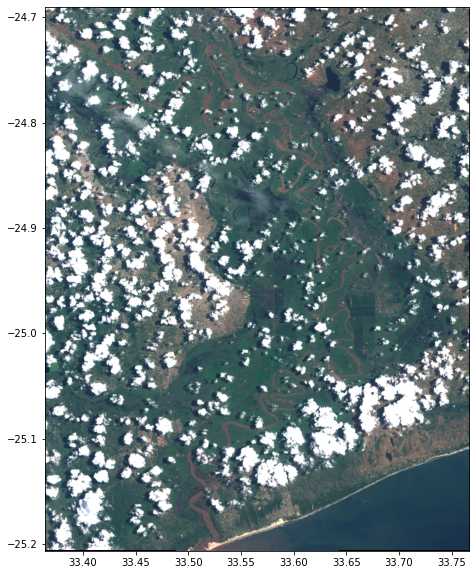

<AxesSubplot:>

In [14]:
from rasterio import plot as rasterioplt
import numpy as np

rgb = np.clip(image[(3,2,1),...]/3000.,0,1)
    
rasterioplt.show(rgb, transform=transform)